## ADF Time Series Plots

#### This notebook is intended for the global and annual averaging of variables

* Please see other notebook about seasonal weighting...

---

In [1]:
import os.path
import sys
from pathlib import Path

# Import necessary packages for the new script
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D

import xarray as xr

### Setting up the ADF

In [2]:
# Determine ADF directory path
# If it is in your cwd, set adf_path = local_path, 
# otherwise set adf_path appropriately

local_path = os.path.abspath('')

# Set path for ADF branch
adf_path = "/glade/work/richling/ADF/ADF_dev/Justin_ADF/ADF"

print(f"current working directory = {local_path}")
print(f"ADF path                  = {adf_path}")

# Set path to ADF lib
lib_path = os.path.join(adf_path,"lib")

# Add paths to python path:
sys.path.append(lib_path)

# Import ADF diagnostics object
from adf_diag import AdfDiag

# Set name of config YAML file:
config_fil_str = "config_timeseries_example.yaml"

# Set path for config YAML file
config_path = "/glade/p/cgd/amp/ADF/timeseries/examples/"

config_file=os.path.join(config_path,config_fil_str)

# Initialize ADF object
adfobj = AdfDiag(config_file)

# Add plot location if needed
plot_path = "./"

print("Good to move on.")

current working directory = /glade/work/richling/ADF/ADF_dev/notebooks
ADF path                  = /glade/work/richling/ADF/ADF_dev/Justin_ADF/ADF
No given climo years for baseline...
No given climo years for case...
No given climo years for case...
No given climo years for case...
No given climo years for case...
No given climo years for case...
No given climo years for case...
Good to move on.


---

### Run these cells if time series files have not yet been created
* these will be created based off configurations in YAML file

---

### Get all case names and time series file locations (including baseline)

In [3]:
case_names = adfobj.get_cam_info('cam_case_name', required=True)
case_names_len = len(case_names)
data_name = adfobj.get_baseline_info('cam_case_name', required=True)

case_ts_loc = adfobj.get_cam_info("cam_ts_loc", required=True)
data_ts_loc = adfobj.get_baseline_info("cam_ts_loc", required=True)
 
res = adfobj.variable_defaults # dict of variable-specific plot preferences
# or an empty dictionary if use_defaults was not specified in YAML.

case_ts_loc, data_ts_loc

(['/glade/p/cgd/amp/ADF/timeseries/examples/b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016/',
  '/glade/p/cgd/amp/ADF/timeseries/examples/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.023/',
  '/glade/p/cgd/amp/ADF/timeseries/examples/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.025a/',
  '/glade/p/cgd/amp/ADF/timeseries/examples/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.025b/',
  '/glade/p/cgd/amp/ADF/timeseries/examples/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026a/',
  '/glade/p/cgd/amp/ADF/timeseries/examples/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026b/'],
 '/glade/p/cgd/amp/ADF/timeseries/examples/b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009/')

---

In [4]:
def _load_dataset(fils):
    if len(fils) == 0:
        print("Input file list is empty.")
        return None
    elif len(fils) > 1:
        return xr.open_mfdataset(fils, combine='by_coords')
    else:
        sfil = str(fils[0])
        return xr.open_dataset(sfil)
    #End if
#End def

In [5]:
def _data_calcs(ts_loc,var,subset=None):
    """
    args
    ----
     - ts_loc: Path
         path to time series file
         
     - var: str
         name of variable
         
     - subset: dict 
         lat/lon extents (south, north, east, west)
    """
    fils = sorted(list(Path(ts_loc).glob(f"*{var}*.nc")))

    ts_ds = _load_dataset(fils)
    
    time = ts_ds['time']
    time = xr.DataArray(ts_ds['time_bnds'].load().mean(dim='nbnd').values, dims=time.dims, attrs=time.attrs)
    ts_ds['time'] = time
    ts_ds.assign_coords(time=time)
    ts_ds = xr.decode_cf(ts_ds)
    
    if subset != None:
        ts_ds = ts_ds.sel(lat=slice(subset["s"],subset["n"]), lon=slice(subset["w"],subset["e"])) 
    
    data = ts_ds[var].squeeze()
    unit = data.units
    
    # global weighting
    w = np.cos(np.radians(data.lat))
    avg = data.weighted(w).mean(dim=("lat","lon"))
    
    yrs = np.unique([str(val.item().timetuple().tm_year).zfill(4) for _,val in enumerate(ts_ds["time"])])

    return avg,yrs,unit

In [6]:
def ts_plot(ax, name, vals, yrs, unit, color_dict):
    """
    args
    ----
     - color_dict: dict
         color and marker style for variable
    """

    ax.plot(yrs, vals, color_dict["marker"], c=color_dict["color"],label=name)

    ax.set_xlabel("Years",fontsize=15,labelpad=20)
    ax.set_ylabel(unit,fontsize=15,labelpad=20)  

    # For the minor ticks, use no labels; default NullFormatter.
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=5)  

    # x-axis ticks and numbers
    if len(yrs_base) >= 10:
        ax.xaxis.set_major_locator(MultipleLocator(5))
    if 0 < len(yrs_base) < 10:
        ax.xaxis.set_major_locator(MultipleLocator(1))
    # For the minor ticks, use no labels; default NullFormatter.
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
    return ax

In [7]:
def plot_var_details(ax, var, vals_cases, vals_base):
    
    mins = []
    maxs = []
    for i,val in enumerate(vals_cases):

        mins.append(np.nanmin(vals_cases[i]))
        maxs.append(np.nanmax(vals_cases[i]))

    mins.append(np.nanmin(vals_base))
    maxs.append(np.nanmax(vals_base))

    if var == "SST":         
        ax.set_ylabel("K",fontsize=20,labelpad=12)
        tick_spacing = 0.5
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.set_title(f"Time Series Global: {var} - ANN",loc="left")

    if var == "TS":
        ax.set_ylabel("K",fontsize=20,labelpad=12)
        tick_spacing = 0.5
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.set_title(f"Time Series Global: {var} - ANN",loc="left")

    if var == "ICEFRAC":
        ax.set_ylabel("frac",fontsize=20,labelpad=12)
        tick_spacing = 0.1
        ax.set_ylim(np.floor(min(mins)),np.ceil(max(maxs)))
        ax.set_title(f"Time Series LabSea: {var} - ANN",loc="left")

    if var == "RESTOM":
        ax.set_ylabel("W/m2",fontsize=20,labelpad=12)
        tick_spacing = 0.5
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))
        ax.set_title(f"Time Series Global: {var} - ANN",loc="left")
        
        # Set label to show if RESTOM is 1 or 5-yr avg
        line_1yr = Line2D([], [], label='1-yr avg', color='k', linewidth=1,marker='*',)              
        line_5yr = Line2D([], [], label='5-yr avg', color='k', linewidth=1,)
        ax.legend(handles=[line_1yr,line_5yr], bbox_to_anchor=(0.99, 0.99))
    
    # Add extra space on the y-axis, except for ICEFRAC
    if var != "ICEFRAC":
        ax.set_ylim(np.floor(min(mins)),np.ceil(max(maxs))+tick_spacing)
        
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        
    return ax

In [8]:
def make_fig_legend(ax,fig,custom_legend=False):
    """
    Function to generate legend and labels for all plots
        * This will be one legend with all cases along side all
           the subplots 
    
    """
    
    # Gather labels based on case names and plotted line format (color, style, etc)
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    
    #Option for custom legend, if not go with standard matplotlib legend creation
    if custom_legend == True:
        """
        Make your own custom legend
        ---------------------------
        
        Number of lables must equal number of plotted lines
        """
        labels = ["009: Target (CAM-dev/SE/L58 + MOM6 + CICE6 + BWsc + NLtopo)",
                  "016: Control (CAM6/FV/L32 + MOM6 + CICE5)",
                  "023",
                  "026a",
                  "026b",
                  ]
        fig.legend(lines[:case_names_len+1], labels,loc="center left",fontsize=16,
                                    bbox_to_anchor=(0.4, 0.25,.05,.05)) #bbox_to_anchor(x0, y0, width, height)
    else:
        """
        Defualt matplotlib legend
        -------------------------
        This will just plot the colored lines and case names as given by the adf obj
        """
        fig.legend(lines[:case_names_len+1], labels[:case_names_len+1],loc="center left",fontsize=16,
                                    bbox_to_anchor=(0.4, 0.25,.05,.05)) #bbox_to_anchor(x0, y0, width, height)
    return fig

---

### Plot the time series!

In [9]:
# Grab variables form YAML file
var_list = adfobj.diag_var_list
print(var_list)

# Make a separate list than what's provided in YAML file
# This is to remove FSNT and FLNT
drop = {"FSNT","FLNT"}
ts_var_list = [e for e in var_list if e not in drop]

# This is to add RESTOM
ts_var_list += ["RESTOM"]
ts_var_list

['FLNT', 'FSNT', 'SST', 'TS', 'ICEFRAC']


['SST', 'TS', 'ICEFRAC', 'RESTOM']

Plotting variable: SST
Plotting variable: TS
Plotting variable: ICEFRAC
Plotting variable: RESTOM
CPU times: user 10.9 s, sys: 4.47 s, total: 15.3 s
Wall time: 22.8 s


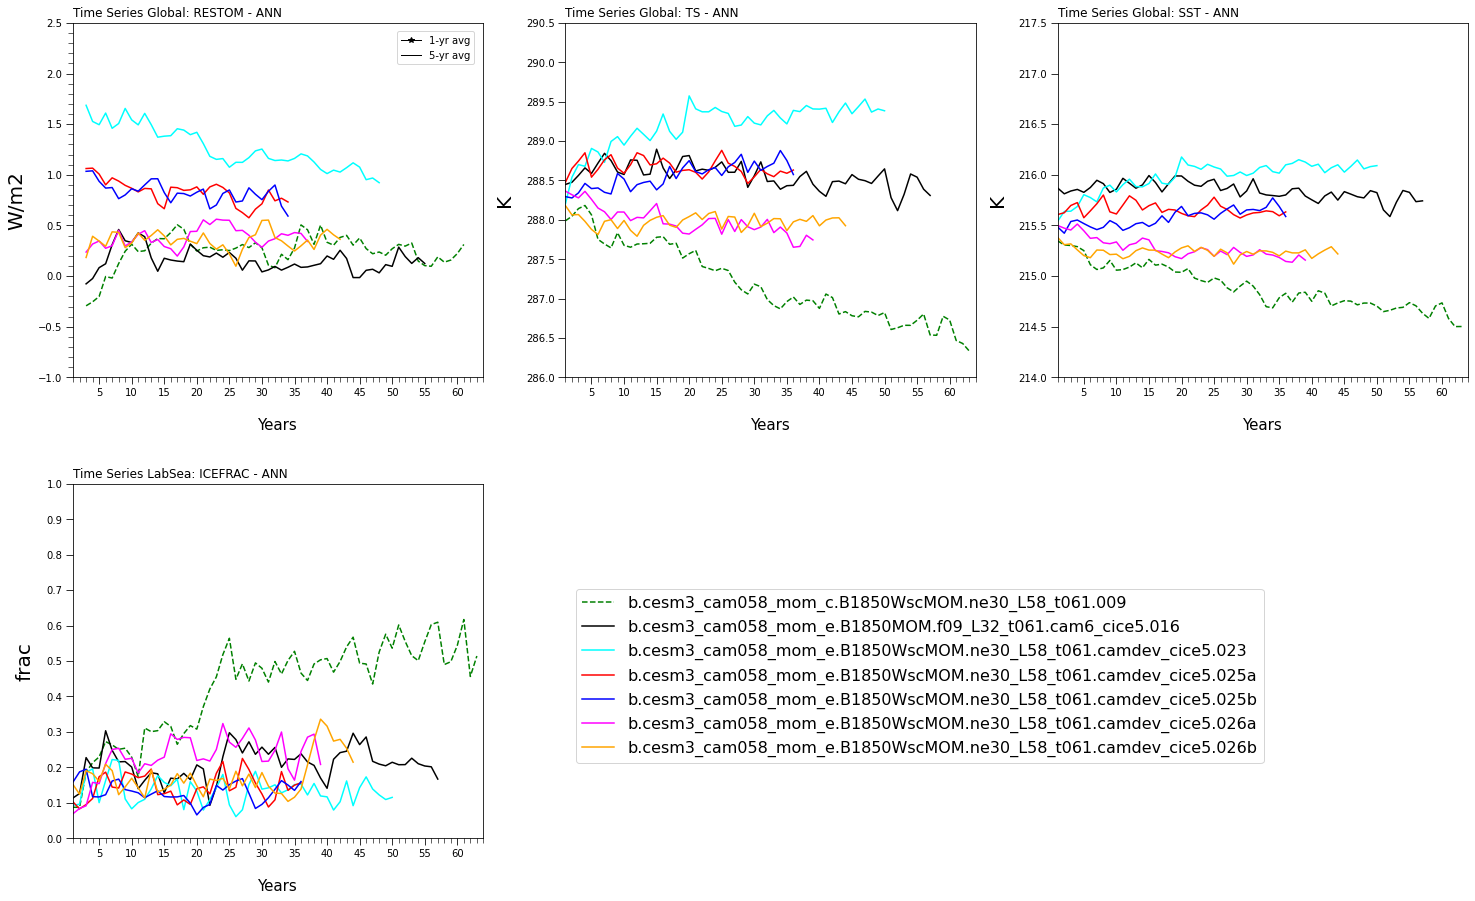

In [10]:
%%time

fig = plt.figure(figsize=(25,15))

# Change the layout/number of subplots based off number of variables desired
gs = fig.add_gridspec(2, 3, hspace=.3, wspace=.2)

# Subset for Lab Sea
'''
w = -64.+360
e = -44+360
s = 53
n = 67
'''
w = -63.5+360
e = -47.5+360
s = 53.5
n = 65.5
subset = {"s":s,"n":n,"e":e,"w":w}

# Add more colors as needed for number of test cases
# ** Baseline is already added as green dashed line in plotting function **
# matplotlib colors here: https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ["k", "aqua", "r", "b", "magenta", "orange", "slategrey", "rosybrown"]

case_names_len = len(case_names)

# Loop over variables:
for var in ts_var_list:
        
    print("Plotting variable:",var)
        
    if var == "RESTOM":
        ax = plt.subplot(gs[0, 0])
    if var == "TS":
        ax = plt.subplot(gs[0, 1])
    if var == "SST":
        ax = plt.subplot(gs[0, 2])
    if var == "ICEFRAC":
        ax = plt.subplot(gs[1, 0])
        
        
    # Grab baseline case:
    #--------------------

    if var == "RESTOM":            
        avg_base_FSNT,yrs_base,unit = _data_calcs(data_ts_loc,'FSNT')
        avg_base_FLNT,_,_ = _data_calcs(data_ts_loc,"FLNT")
        if len(yrs_base) < 30:
            print(f"Not a lot of climo years for {data_name}, only doing 1-yr avg for RESTOM...")
            FSNT_base = avg_base_FSNT
            FLNT_base = avg_base_FLNT
        else:
            FSNT_base = avg_base_FSNT.rolling(time=60,center=True).mean()
            FLNT_base = avg_base_FLNT.rolling(time=60,center=True).mean()

        avg_base = FSNT_base - FLNT_base
            
    if (var == "TS" or var == "SST"):
        avg_base,yrs_base,unit = _data_calcs(data_ts_loc,var)
                
    if var == "ICEFRAC":
        avg_base,yrs_base,unit = _data_calcs(data_ts_loc,var,subset)
    
    # Get int of years for plotting on x-axis
    yrs_base_int = yrs_base.astype(int)

    # Create yearly averages
    vals_base = [avg_base.sel(time=i).mean() for i in yrs_base]
        
    color_dict = {"color":"g","marker":"--"}
    ax = ts_plot(ax, data_name, vals_base, yrs_base_int, unit, color_dict)
        
        
    # Loop over test cases:
    #----------------------
        
    # Create lists to hold all sets of years (for each case) and
    # sets of var data (for each case)
    vals_cases = []
    yrs_cases = []
    for case_idx, case_name in enumerate(case_names):

        if var == "RESTOM":
            avg_case_FSNT,yrs_case,unit = _data_calcs(case_ts_loc[case_idx],'FSNT')
            avg_case_FLNT,_,_ = _data_calcs(case_ts_loc[case_idx],"FLNT")
            if len(yrs_case) < 30:
                print(f"Not a lot of climo years for {case_name}, only doing 1-yr avg for RESTOM...")
                FSNT_case = avg_case_FSNT
                FLNT_case = avg_case_FLNT
                color_dict = {"color":colors[case_idx],"marker":"-*"}
            else:
                FSNT_case = avg_case_FSNT.rolling(time=60,center=True).mean()
                FLNT_case = avg_case_FLNT.rolling(time=60,center=True).mean()
                color_dict = {"color":colors[case_idx],"marker":"-"}

            avg_case = FSNT_case - FLNT_case

        if (var == "TS" or var == "SST"):
            avg_case,yrs_case,unit = _data_calcs(case_ts_loc[case_idx],var)
            color_dict = {"color":colors[case_idx],"marker":"-"}
                
        if var == "ICEFRAC":
            avg_case,yrs_case,unit = _data_calcs(case_ts_loc[case_idx],var,subset)
            color_dict = {"color":colors[case_idx],"marker":"-"}
                
        # Get yearly averages for all available years
        vals_case = [avg_case.sel(time=i).mean() for i in yrs_case]
        vals_cases.append(vals_case)
            
        # Get int of years for plotting on x-axis
        yrs_case_int = yrs_case.astype(int)
        yrs_cases.append(yrs_case_int)
        
        # Add case to plot (ax)
        ax = ts_plot(ax, case_name, vals_case, yrs_case_int, unit, color_dict)
    # End for (case names)
        
    
    # Get variable details
    ax = plot_var_details(ax, var, vals_cases, vals_base)
        
    # Grab the earliest and latest climo years of all cases excluding baseline
    yrs_cases_min = min([min(i) for i in yrs_cases])
    yrs_cases_max = max([max(i) for i in yrs_cases])
        
    # Set the x-axis plot limits
    # to guarantee data from all cases (including baseline) are on plot
    ax.set_xlim(min(yrs_cases_min,min(yrs_base_int)),
                    max([yrs_cases_max,max(yrs_base_int)])+1) 
        
# End for (variables loop)
    
# Set up legend
# If custom_legend = True, change the code in make_fig_legend() function for custom legend
fig = make_fig_legend(ax, fig, custom_legend=False)
    
plt.savefig(f"{plot_path}TimeSeries_ANN.png", facecolor='w')